# # # **Problem statement**: To build a CNN based model which can accurately detect melanoma. 

In [2]:
import warnings
warnings.filterwarnings('ignore')


#### Import needed libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model

In [4]:
## This notebook is being run in Kaggle, checking if GPU is enabled
tf.config.list_physical_devices('GPU')

2022-11-15 23:55:41.514183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:41.515236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:41.679438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:41.680348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:41.681210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
## Define the trainging and test path directories
## For this assignment, moved Test and Train folders into parent folder melimgs 
## and uploaded zip to kaggale input directory

data_dir_train = pathlib.Path("/kaggle/input/melimgs/Train")
data_dir_test = pathlib.Path("/kaggle/input/melimgs/Test")

In [6]:
## Using pathlib glob module, print the count of images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images count= ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images count= ", image_count_test)

Train images count=  2239
Test images count=  118


#### Define parameters batch size and image dimensions

In [7]:
batch_size = 32
img_height = 180
img_width = 180

#### Load training images, perform a 80(train) and 20(validation) split

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-11-15 23:55:50.019868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 23:55:50.273676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:50.274442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:55:50.275206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Load Test data provided to make predictions once model is trained

In [10]:
## Load test data fro final predictions (no test train split here)
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width))

## Get the file path
test_file_paths = test_ds.file_paths

## Store the file name and given class in the Test directory in data frame
test_ds_given_df=pd.DataFrame()
for file in test_file_paths:
    test_ds_given_df= test_ds_given_df.append({"GivenClass":file.split('/')[-2],"GivenFile":file.split('/')[-1]},ignore_index=True)

Found 118 files belonging to 9 classes.


In [11]:
## reset the index for test files data frame to filename
test_ds_given_df=test_ds_given_df.set_index("GivenFile")
test_ds_given_df

,GivenClass
GivenFile,
ISIC_0024511.jpg,actinic keratosis
ISIC_0024408.jpg,pigmented benign keratosis
ISIC_0000035.jpg,melanoma
ISIC_0024358.jpg,pigmented benign keratosis
ISIC_0024454.jpg,basal cell carcinoma
...,...
ISIC_0011751.jpg,squamous cell carcinoma
ISIC_0010809.jpg,seborrheic keratosis
ISIC_0024412.jpg,pigmented benign keratosis


#### Obtain the class names in train data

In [12]:
class_names = train_ds.class_names
print(class_names)
print("Total Clases:" , len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Clases: 9


#### Print image from each class for visualization

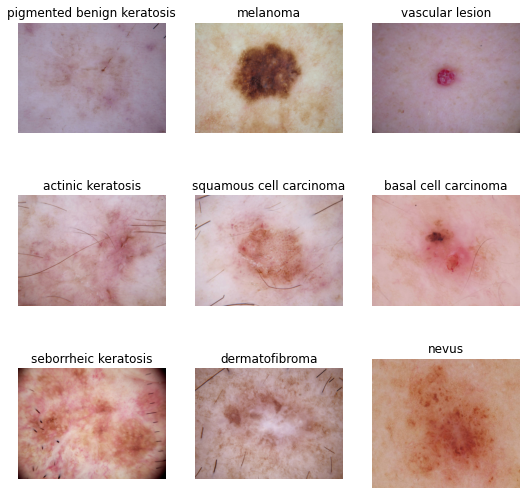

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
i=0;
for dirpath, dirnames, files in os.walk(str(data_dir_train)):    
    for file in [f for f in files if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(file))
        plt.subplot(3,3,i+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        i=i+1
 
    

#### Performance related settings
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 : Basic Model 

In [21]:
model1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(32, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
  tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [22]:
# summary of the model
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 64)       

In [23]:
# compile the model with sgd optimizer
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [25]:
# Training the model
m1_fit = model1.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25
56/56 [==============================] - 8s 123ms/step - loss: 2.7536 - accuracy: 0.3398 - val_loss: 2.2037 - val_accuracy: 0.1521
Epoch 2/25
56/56 [==============================] - 2s 44ms/step - loss: 1.4011 - accuracy: 0.5045 - val_loss: 2.4998 - val_accuracy: 0.1566
Epoch 3/25
56/56 [==============================] - 2s 44ms/step - loss: 1.1945 - accuracy: 0.5720 - val_loss: 3.8009 - val_accuracy: 0.1521
Epoch 4/25
56/56 [==============================] - 2s 43ms/step - loss: 1.0387 - accuracy: 0.6239 - val_loss: 3.7315 - val_accuracy: 0.1566
Epoch 5/25
56/56 [==============================] - 2s 43ms/step - loss: 0.8617 - accuracy: 0.6847 - val_loss: 3.9189 - val_accuracy: 0.1678
Epoch 6/25
56/56 [==============================] - 2s 44ms/step - loss: 0.7345 - accuracy: 0.7266 - val_loss: 3.1583 - val_accuracy: 0.2573
Epoch 7/25
56/56 [==============================] - 2s 43ms/step - loss: 0.5712 - accuracy: 0.7952 - val_loss: 2.1638 - val_accuracy: 0.4004
Epoch 8/25
5

* Observation for Model 1 : Training accuracy of 83% Validation accuracy of 52%
* Inference: Clearly there is an overfit. Also accuracy is low as probably layers in the model are not enough

## Model 2 : Build a custom VGG16 model

In [91]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [92]:
# compile the model with adam optimizer
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

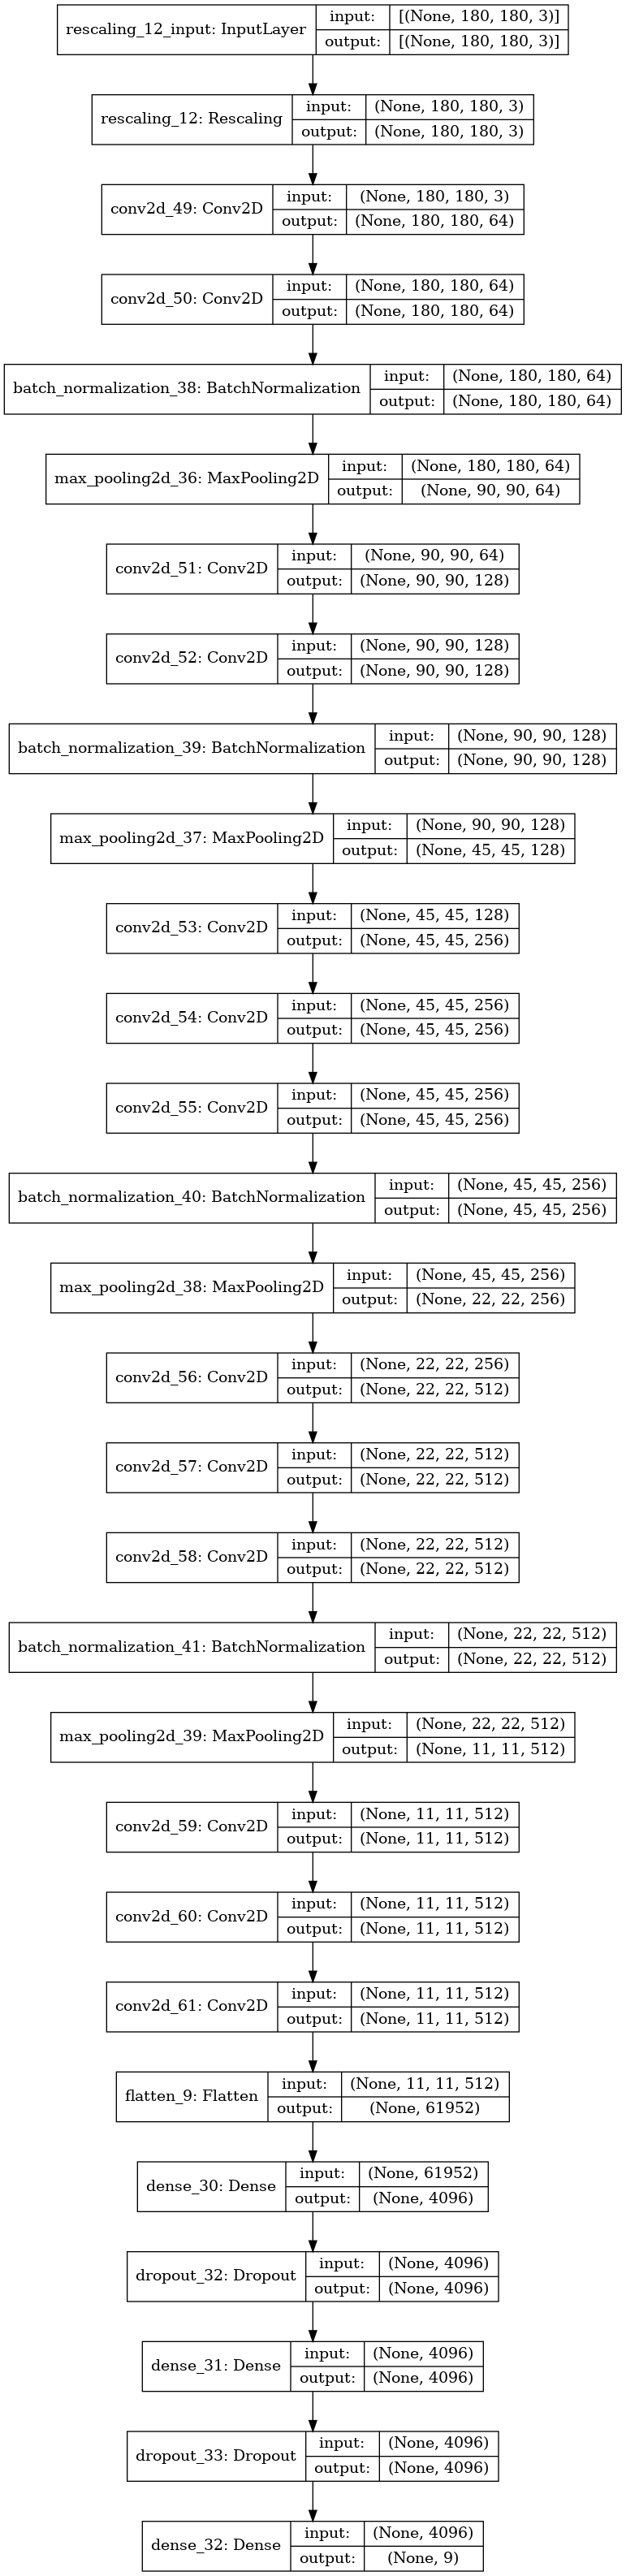

In [93]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [94]:
# summary of the model
print(model2.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization_38 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 90, 90, 128)     

In [95]:
# Training the model
m2_fit = model.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25
56/56 [==============================] - 5s 98ms/step - loss: 0.4424 - accuracy: 0.8209 - val_loss: 4.8662 - val_accuracy: 0.4474
Epoch 2/25
56/56 [==============================] - 5s 97ms/step - loss: 0.4462 - accuracy: 0.8270 - val_loss: 16.7305 - val_accuracy: 0.2662
Epoch 3/25
56/56 [==============================] - 6s 98ms/step - loss: 0.4170 - accuracy: 0.8354 - val_loss: 3.0007 - val_accuracy: 0.5526
Epoch 4/25
56/56 [==============================] - 6s 99ms/step - loss: 0.3977 - accuracy: 0.8326 - val_loss: 3.1208 - val_accuracy: 0.5548
Epoch 5/25
56/56 [==============================] - 6s 99ms/step - loss: 0.4024 - accuracy: 0.8354 - val_loss: 3.7285 - val_accuracy: 0.5391
Epoch 6/25
56/56 [==============================] - 6s 100ms/step - loss: 0.4115 - accuracy: 0.8237 - val_loss: 2.6957 - val_accuracy: 0.3848
Epoch 7/25
56/56 [==============================] - 6s 100ms/step - loss: 0.3832 - accuracy: 0.8354 - val_loss: 3.2005 - val_accuracy: 0.5481
Epoch 8/25

* Observation for Model 2 : Training accuracy has slightly improved
* Inference: Clearly there is an overfit. Also accuracy is low as probably layers in the model are not enough

In [37]:
def plt_model (model_fit,epochs):
    train_acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    
    train_loss = model_fit.history['loss']
    val_loss = model_fit.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

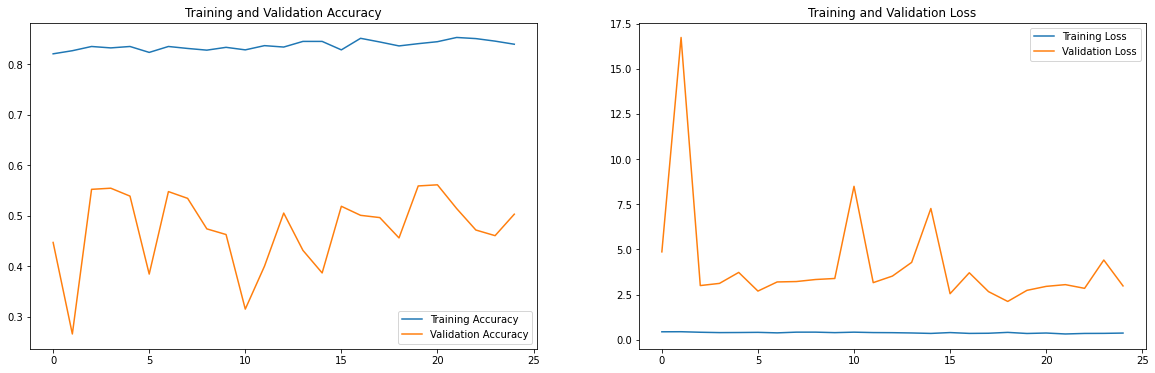

In [97]:
 plt_model (m2_fit,epochs=25)

Observation:
There is an overfit in model (Training accuracy is higher than test accuracy)
There are two possible reasons:
1) The training data images and the validation images have significan differences and hence the model is unable to take the learning forward. This can be attempted to fix by using Data augmentation to introduce some cropping , rotation etc
2) Class imbalance - there is an imbalance of classes across training and test sets and model is not able to train efficently

### Define a sequential Data Augmentation Layer

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [16]:
model3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),  
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [17]:
# summary of the model
print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 64)       

In [18]:
# compile the model with adam optimizer
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Training the model
m3_fit = model3.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25


2022-11-15 23:56:36.130422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-15 23:56:46.517946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 33 of 1000
2022-11-15 23:56:50.287482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-15 23:56:51.621448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 53s 394ms/step - loss: 2.7052 - accuracy: 0.2857 - val_loss: 2.2713 - val_accuracy: 0.1655
Epoch 2/25
56/56 [==============================] - 15s 261ms/step - loss: 1.8707 - accuracy: 0.3287 - val_loss: 2.3115 - val_accuracy: 0.1902
Epoch 3/25
56/56 [==============================] - 15s 265ms/step - loss: 1.7583 - accuracy: 0.3717 - val_loss: 2.3396 - val_accuracy: 0.1991
Epoch 4/25
56/56 [==============================] - 15s 270ms/step - loss: 1.7138 - accuracy: 0.4023 - val_loss: 2.2874 - val_accuracy: 0.2327
Epoch 5/25
56/56 [==============================] - 16s 277ms/step - loss: 1.6817 - accuracy: 0.3929 - val_loss: 1.8917 - val_accuracy: 0.3602
Epoch 6/25
56/56 [==============================] - 16s 286ms/step - loss: 1.6705 - accuracy: 0.3778 - val_loss: 2.2972 - val_accuracy: 0.2237
Epoch 7/25
56/56 [==============================] - 16s 293ms/step - loss: 1.6612 - accuracy: 0.3940 - val_loss: 1.6485 - val_accuracy: 0.4541
Epoch 8/25

#### Let us look at the class imbalance

In [20]:
# store the classes in dataframe for easy analysis
class_size_df = pd.DataFrame()

for name in class_names:
    class_size_df=class_size_df.append({'Class':name,'Size':len(list(data_dir_train.glob(name+'/*.jpg')))},ignore_index = True)

class_size_df = class_size_df.set_index('Class')    

In [21]:
class_size_df

,Size
Class,
actinic keratosis,114.0
basal cell carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented benign keratosis,462.0
seborrheic keratosis,77.0
squamous cell carcinoma,181.0
vascular lesion,139.0


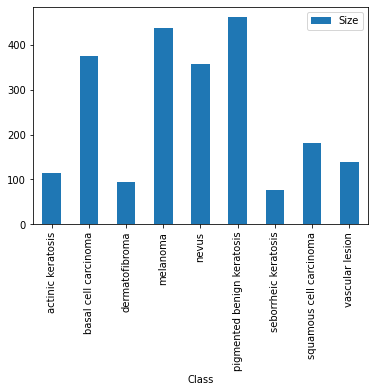

In [22]:
class_size_df.plot.bar()
plt.show()

#### Using Augmentor increase the training data set

In [23]:
!pip install Augmentor
import Augmentor

In [24]:
for i,row in class_size_df.iterrows():
    p = Augmentor.Pipeline('/kaggle/input/melimgs/Train/'+i, output_directory='/kaggle/working/'+i+'/')
    p.flip_left_right(probability=0.3)
    p.flip_top_bottom(probability=0.7)
    p.rotate90(probability=0.1)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(600)

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A30270690>: 100%|██████████| 600/600 [00:23<00:00, 26.08 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A301361D0>: 100%|██████████| 600/600 [00:21<00:00, 27.64 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3029ED10>: 100%|██████████| 600/600 [00:23<00:00, 25.30 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5A3010D7D0>: 100%|██████████| 600/600 [02:10<00:00,  4.60 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/.

Processing <PIL.Image.Image image mode=RGB size=723x957 at 0x7F5A30083310>: 100%|██████████| 600/600 [01:56<00:00,  5.15 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A7C242D10>: 100%|██████████| 600/600 [00:22<00:00, 27.01 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5A30660310>: 100%|██████████| 600/600 [00:54<00:00, 10.94 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A7C104CD0>: 100%|██████████| 600/600 [00:23<00:00, 25.98 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A30742450>: 100%|██████████| 600/600 [00:23<00:00, 25.46 Samples/s]                  


In [25]:
## A hidden directory virtual_documents is being created in kagggle, removing it
import shutil
shutil.rmtree("/kaggle/working/.virtual_documents")


In [26]:
## Print the total training images generated
data_dir_train_aug = pathlib.Path("/kaggle/working/")
image_count_train_aug = len(list(data_dir_train_aug.glob('*/*.jpg')))
print("Train images count= ", image_count_train_aug)

Train images count=  5400


#### Load the new training images generated through augmentor into train_ds_aug

In [27]:
train_ds_aug = tf.keras.utils.image_dataset_from_directory(
  data_dir_train_aug,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5400 files belonging to 9 classes.
Using 4320 files for training.


In [28]:
  
val_ds_aug = tf.keras.utils.image_dataset_from_directory(
  data_dir_train_aug,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 5400 files belonging to 9 classes.
Using 1080 files for validation.


In [29]:
class_names_aug = train_ds_aug.class_names
print(class_names_aug)
print("Total Clases:" , len(class_names_aug))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Clases: 9


In [30]:
class_size_aug_df = pd.DataFrame()

for name in class_names_aug:
    class_size_aug_df=class_size_aug_df.append({'Class':name,'Size':len(list(data_dir_train_aug.glob(name+'/*.jpg')))},ignore_index = True)

class_size_aug_df = class_size_aug_df.set_index('Class')    

In [31]:
class_size_aug_df

,Size
Class,
actinic keratosis,600.0
basal cell carcinoma,600.0
dermatofibroma,600.0
melanoma,600.0
nevus,600.0
pigmented benign keratosis,600.0
seborrheic keratosis,600.0
squamous cell carcinoma,600.0
vascular lesion,600.0


In [52]:
model4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),  
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [53]:
# summary of the model
print(model4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 90, 90, 128)      

In [54]:
# compile the model with adam optimizer
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [55]:
# Training the model
m4_fit = model4.fit(train_ds_aug,epochs=35,validation_data=val_ds_aug,shuffle=True)

Epoch 1/35
135/135 [==============================] - 51s 364ms/step - loss: 2.5055 - accuracy: 0.1590 - val_loss: 2.2025 - val_accuracy: 0.1046
Epoch 2/35
135/135 [==============================] - 49s 360ms/step - loss: 2.0034 - accuracy: 0.1970 - val_loss: 2.2619 - val_accuracy: 0.1019
Epoch 3/35
135/135 [==============================] - 48s 349ms/step - loss: 1.9270 - accuracy: 0.2146 - val_loss: 2.4599 - val_accuracy: 0.1046
Epoch 4/35
135/135 [==============================] - 49s 359ms/step - loss: 1.9000 - accuracy: 0.2095 - val_loss: 2.3154 - val_accuracy: 0.1583
Epoch 5/35
135/135 [==============================] - 49s 355ms/step - loss: 1.8734 - accuracy: 0.2245 - val_loss: 2.0599 - val_accuracy: 0.1880
Epoch 6/35
135/135 [==============================] - 48s 348ms/step - loss: 1.8481 - accuracy: 0.2407 - val_loss: 4.5075 - val_accuracy: 0.1315
Epoch 7/35
135/135 [==============================] - 49s 359ms/step - loss: 1.8324 - accuracy: 0.2287 - val_loss: 2.1067 - val_ac

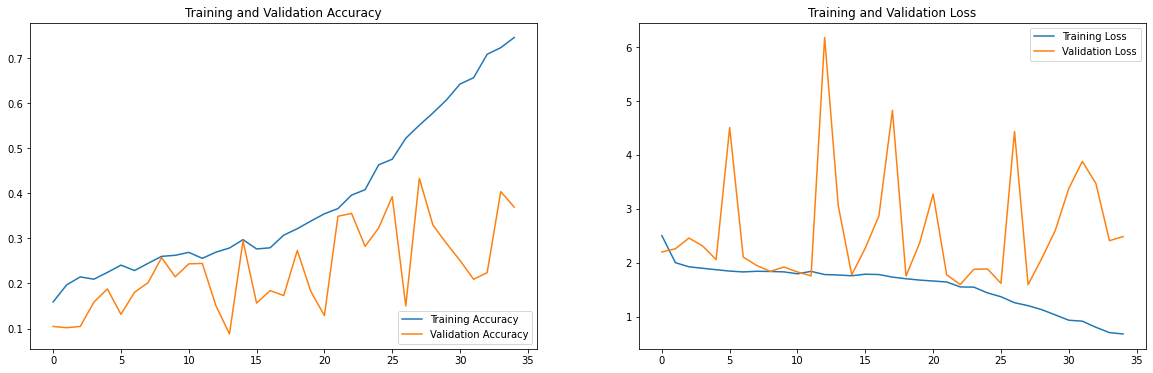

In [56]:
plt_model(m4_fit,epochs=35)

### Make Predictions on Test data

In [57]:
## Load each image in Test directory and make predictions on it
for index,row in test_ds_given_df.iterrows():
    #print("/kaggle/input/melimgs/Test/"+row['GivenClass']+"/"+index)
    img = tf.keras.utils.load_img("/kaggle/input/melimgs/Test/"+row['GivenClass']+"/"+index, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model4.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    test_ds_given_df.at[index,'PredClass']=class_names[np.argmax(score)]
    test_ds_given_df.at[index,'PredConfidence']=100 * np.max(score)

#### Identify the images whose predicted class equals provided class

In [58]:
test_ds_pred_acc=test_ds_given_df[test_ds_given_df.GivenClass==test_ds_given_df.PredClass]

In [59]:
print ('correctly predicted= ',test_ds_pred_acc.shape[0],' Overall accuracy % on prediction =',round(test_ds_pred_acc.shape[0]/test_ds_given_df.shape[0],2)*100)

correctly predicted=  25  Overall accuracy % on prediction = 21.0


In [43]:
test_ds_pred_acc

,GivenClass,PredClass,PredConfidence
GivenFile,,,
ISIC_0024408.jpg,pigmented benign keratosis,pigmented benign keratosis,25.360316
ISIC_0024358.jpg,pigmented benign keratosis,pigmented benign keratosis,15.810688
ISIC_0024454.jpg,basal cell carcinoma,basal cell carcinoma,13.665295
ISIC_0024402.jpg,vascular lesion,vascular lesion,25.356862
ISIC_0024763.jpg,actinic keratosis,actinic keratosis,15.393162
ISIC_0024646.jpg,actinic keratosis,actinic keratosis,14.774342
ISIC_0025368.jpg,actinic keratosis,actinic keratosis,16.754761
ISIC_0000009.jpg,nevus,nevus,18.857627
ISIC_0024396.jpg,dermatofibroma,dermatofibroma,19.794668
